In [32]:
from importlib import reload
from model import *
from train import *
from dataloader import *
import dataloader as _D
reload(_D)
import utils as _U
reload(_U)
from collections import OrderedDict
import yaml

In [36]:
with open('configs/I5R20/I5R20_09-11.yml', 'r') as f:
    setting = _U.Dict2ObjParser(yaml.safe_load(f)).parse()

In [37]:
if 'models' not in os.listdir('./'):
    os.system('mkdir models')
if setting.TRAIN.MODEL_SAVE_FILE.split('/')[1] not in os.listdir('./models/'):
    os.system(f"cd models && mkdir {setting.TRAIN.MODEL_SAVE_FILE.split('/')[1]}")
if 'logs' not in os.listdir('./'):
    os.system('mkdir logs')
if setting.TRAIN.LOG_SAVE_FILE.split('/')[1] not in os.listdir('./logs/'):
    os.system(f"cd logs && mkdir {setting.TRAIN.LOG_SAVE_FILE.split('/')[1]}")

In [35]:
dataset = _D.ImageDataSet(win_size = setting.DATASET.LOOKBACK_WIN, \
                            start_date = setting.DATASET.START_DATE, \
                            end_date = setting.DATASET.END_DATE, \
                            mode = setting.DATASET.MODE, \
                            indicators = setting.DATASET.INDICATORS, \
                            show_volume = setting.DATASET.SHOW_VOLUME, \
                            parallel_num=setting.DATASET.PARALLEL_NUM)

[Load Data] | 2023-04-18 16:22:21 Done | Using  7.955 seconds
TRAIN DataSet Initialized
 	 - Image Size:   (32, 15)
 	 - Time Period:  20091231 - 20111231
 	 - Indicators:   [('MA', ['5'])]
 	 - Volume Shown: True


In [7]:
image_set = dataset.generate_images(setting.DATASET.SAMPLE_RATE)

Generating Images: 100%|██████████| 2283/2283 [02:15<00:00, 16.79it/s]


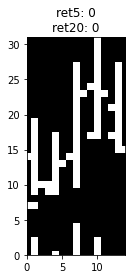

In [5]:
display_image(image_set[0])

In [8]:
train_loader_size = int(len(image_set)*(1-setting.TRAIN.VALID_RATIO))
valid_loader_size = len(image_set) - train_loader_size

train_loader, valid_loader = torch.utils.data.random_split(image_set, [train_loader_size, valid_loader_size])
train_loader = torch.utils.data.DataLoader(dataset=train_loader, batch_size=setting.TRAIN.BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_loader, batch_size=setting.TRAIN.BATCH_SIZE, shuffle=False)

In [9]:
model_d5 = CNN5d()
model_d5.to(device)

CNN5d(
  (conv1): Sequential(
    (Conv): Conv2d(1, 64, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
    (BN): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ReLU): ReLU()
    (Max-Pool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (Conv): Conv2d(64, 128, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
    (BN): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (ReLU): ReLU()
    (Max-Pool): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (DropOut): Dropout(p=0.5, inplace=False)
  (FC): Linear(in_features=15360, out_features=2, bias=True)
  (Softmax): Softmax(dim=1)
)

In [10]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model_d5.parameters(), lr=setting.TRAIN.LEARNING_RATE, weight_decay=setting.TRAIN.WEIGHT_DECAY)

In [12]:
train_loss_set, valid_loss_set, train_acc_set, valid_acc_set = train_n_epochs(10, model_d5, setting.TRAIN.LABEL, train_loader, valid_loader, criterion, optimizer, setting.TRAIN.MODEL_SAVE_FILE)

Epoch: 1 Training Loss: 1.039677 Validation Loss: 0.749363 Training Acc: 0.50903 Validation Acc: 0.50018
Validation loss decreased (inf --> 0.749363).  Saving model ...
Epoch: 2 Training Loss: 1.000116 Validation Loss: 0.737045 Training Acc: 0.51406 Validation Acc: 0.51456
Validation loss decreased (0.749363 --> 0.737045).  Saving model ...
Epoch: 3 Training Loss: 0.977291 Validation Loss: 0.728786 Training Acc: 0.51223 Validation Acc: 0.50792
Validation loss decreased (0.737045 --> 0.728786).  Saving model ...
Epoch: 4 Training Loss: 0.965576 Validation Loss: 0.725439 Training Acc: 0.51582 Validation Acc: 0.50428
Validation loss decreased (0.728786 --> 0.725439).  Saving model ...
Epoch: 5 Training Loss: 0.947316 Validation Loss: 0.726084 Training Acc: 0.51449 Validation Acc: 0.52622
Epoch: 6 Training Loss: 0.944108 Validation Loss: 0.722931 Training Acc: 0.51028 Validation Acc: 0.52330
Validation loss decreased (0.725439 --> 0.722931).  Saving model ...
Epoch: 7 Training Loss: 0.9163

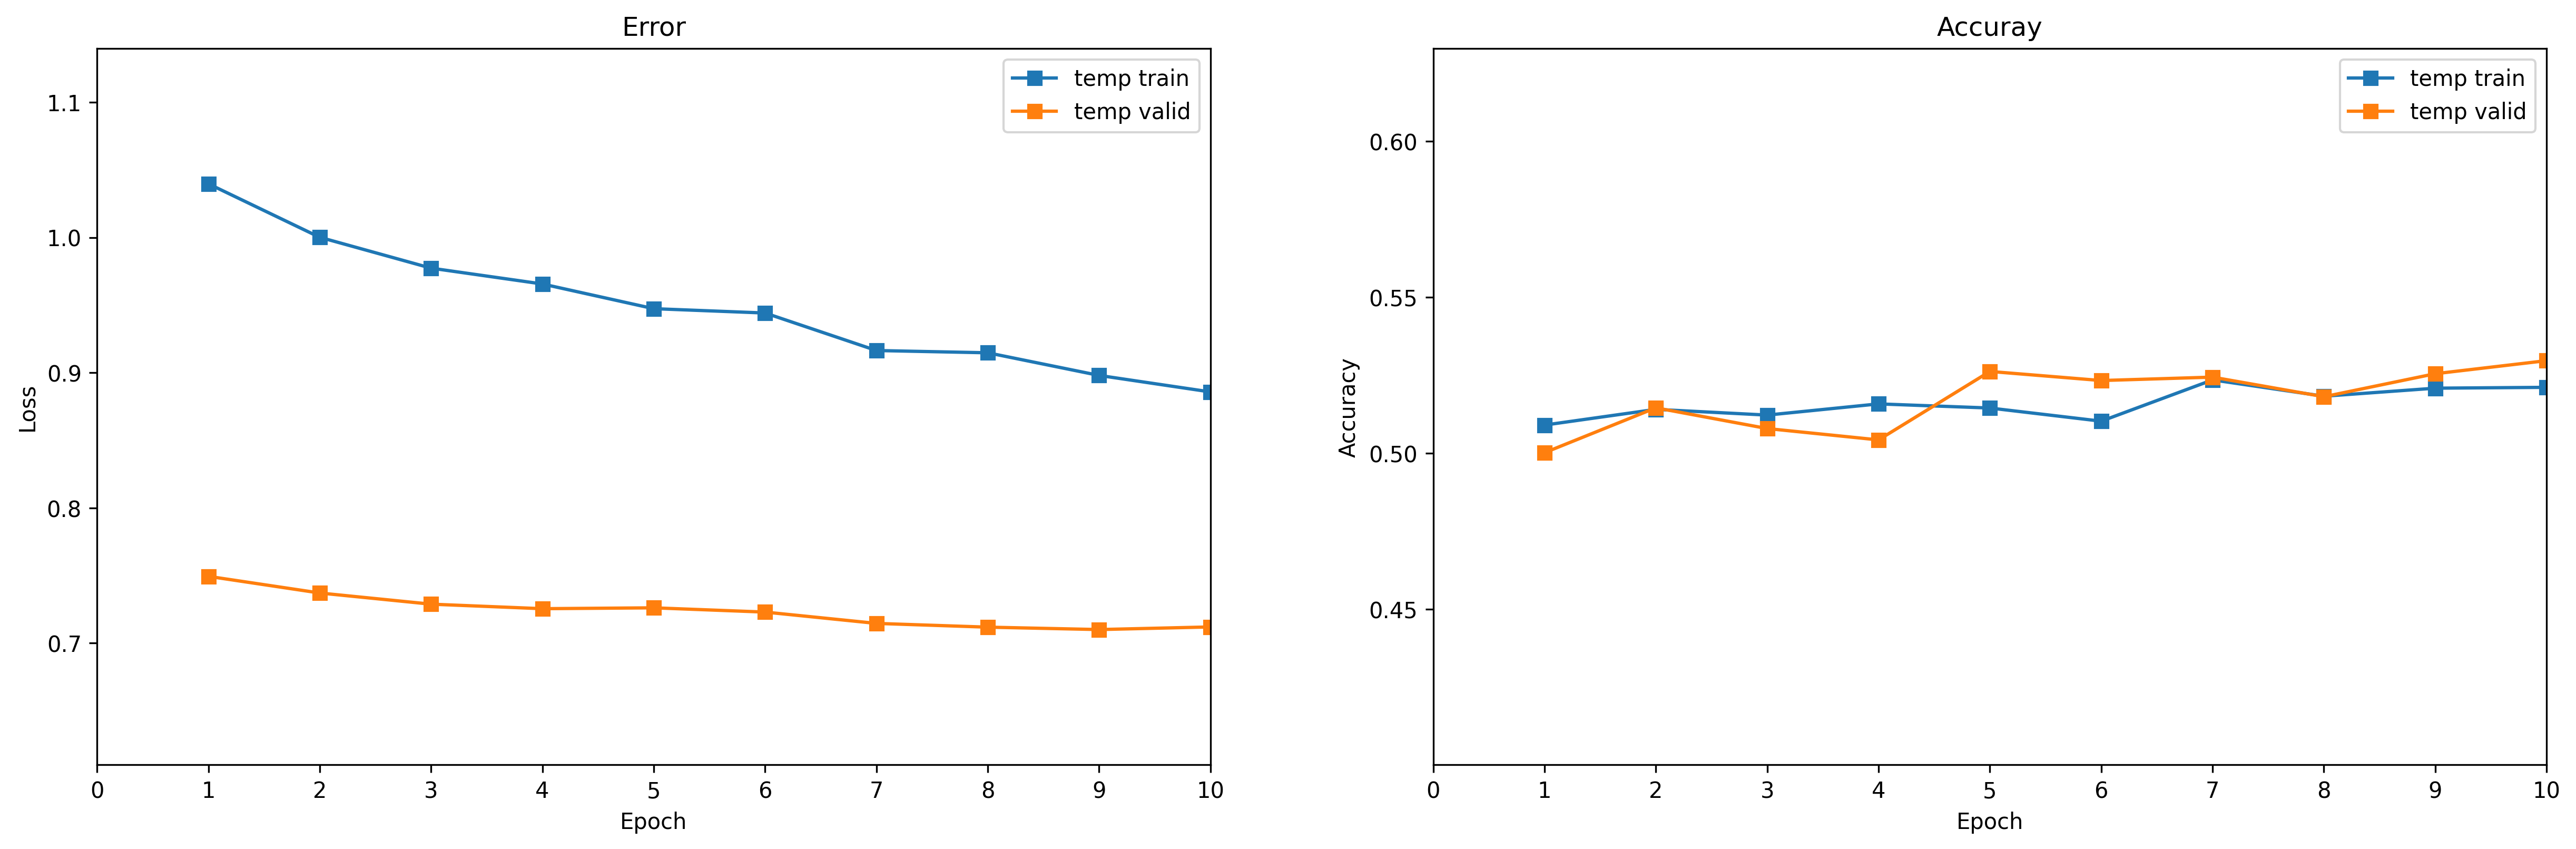

In [13]:
plot_loss_and_acc({"temp train": [train_loss_set, train_acc_set], \
                    "temp valid": [valid_loss_set, valid_acc_set]})

In [26]:
log = pd.DataFrame([train_loss_set, train_acc_set, valid_loss_set, valid_acc_set], index=['train_loss', 'train_acc', 'valid_loss', 'valid_acc'])
log.to_csv(setting.TRAIN.LOG_SAVE_FILE)